# Analytics - reference-only analysis

In this notebook, we will see how to leverage a pre-trained model and latent dataset to:
- Perform analysis in the low dimensional space (latent space), e.g. UMAP, clustering, DE
- ~~Extract high dimensional insight from the data, e.g. get denoised gene expression, generate posterior predictive samples~~
- Evaluate the goodness of fit of the model (using PPC with metrics such as cofficient of variation and DE)
- ~~Evaluate imputation accuracy of the model in imputing missing data~~

In [3]:
import scvi_hub
import scvi
import anndata
import pandas as pd
import numpy as np
import scanpy as sc
import torch
import gc
import matplotlib.pyplot as plt
import math
import mplscience
import seaborn as sns
import scipy

# plotting command for the styling
sns.reset_orig()

%load_ext autoreload
%autoreload 2

Global seed set to 0
/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


# 0️⃣ Where to download the data from?

- "/Users/valehvpa/GitRepos/scvi-hub/local/data_stuff/HLCA/hlca_new/full_data/HLCA_v1_extended_raw_counts_2000hvgs.h5ad"  
-> downloaded from here: https://beta.fastgenomics.org/datasets/detail-dataset-427f1eee6dd44f50bae1ab13f0f3c6a9#Files   
- "/Users/valehvpa/GitRepos/scvi-hub/local/data_stuff/HLCA/hlca_new/full_data/HLCA_v1.h5ad"  
-> downloaded from here: https://beta.fastgenomics.org/datasets/detail-dataset-427f1eee6dd44f50bae1ab13f0f3c6a9#Files   
- "/Users/valehvpa/GitRepos/scvi-hub/local/data_stuff/HLCA/hlca_new/HLCA_reference_model/"  
-> downloaded from here: https://zenodo.org/record/6337966/files/HLCA_reference_model.zip

## 1️⃣ Prepare and load HLCA core model in latent mode

### Prepare

Here we use the HLCA dataset.

An integrated cell atlas of the human lung in health and disease
L Sikkema, D Strobl, L Zappia, E Madissoon, NS Markov, L Zaragosi, M Ansari, M Arguel, L Apperloo, C Bécavin, M Berg, E Chichelnitskiy, M Chung, A Collin, ACA Gay, B Hooshiar Kashani, M Jain, T Kapellos, TM Kole, C Mayr, M von Papen, L Peter, C Ramírez-Suástegui, J Schniering, C Taylor, T Walzthoeni, C Xu, LT Bui, C de Donno, L Dony, M Guo, AJ Gutierrez, L Heumos, N Huang, I Ibarra, N Jackson, P Kadur Lakshminarasimha Murthy, M Lotfollahi, T Tabib, C Talavera-Lopez, K Travaglini, A Wilbrey-Clark, KB Worlock, M Yoshida, Lung Biological Network Consortium, T Desai, O Eickelberg, C Falk, N Kaminski, M Krasnow, R Lafyatis, M Nikolíc, J Powell, J Rajagopal, O Rozenblatt-Rosen, MA Seibold, D Sheppard, D Shepherd, SA Teichmann, A Tsankov, J Whitsett, Y Xu, NE Banovich, P Barbry, TE Duong, KB Meyer, JA Kropski, D Pe’er, HB Schiller, PR Tata, JL Schultze, AV Misharin, MC Nawijn, MD Luecken, F Theis
bioRxiv 2022.03.10.483747; doi: https://doi.org/10.1101/2022.03.10.483747

We've previously converted the model from legacy format to the new format and saved it under "HLCA_reference_model_new" as follows.

In [ ]:
# # Steps to convert legacy save format to new format:
# legacy_path = "/Users/valehvpa/GitRepos/scvi-hub/local/data_stuff/HLCA/hlca_new/HLCA_reference_model"
# new_path = "/Users/valehvpa/GitRepos/scvi-hub/local/data_stuff/HLCA/hlca_new/HLCA_reference_model_new"
# scvi.model.SCANVI.convert_legacy_save(legacy_path, new_path)

Similarly, we've previously latent-ified the model and saved it under "HLCA_reference_model_new_latent" as follows.

In [4]:
# # Steps to latent-ified the model:
# qzm, qzv = model.get_latent_representation(give_mean=False, return_dist=True)
# adata.obsm["X_latent_qzm"] = qzm
# adata.obsm["X_latent_qzv"] = qzv
# model.to_latent_mode(mode="dist")
# model.save("/Users/valehvpa/GitRepos/scvi-hub/local/data_stuff/HLCA/hlca_new/HLCA_reference_model_new_latent", save_anndata=True)

### Load

In [33]:
def get_hlca_core_adata():
    adata = anndata.read_h5ad("/Users/valehvpa/GitRepos/scvi-hub/local/data_stuff/HLCA/hlca_new/full_data/HLCA_v1_extended_raw_counts_2000hvgs.h5ad")
    adata = adata[adata.obs.HLCA_core_or_extension == "core", :].copy()

    adata3 = anndata.read_h5ad("/Users/valehvpa/GitRepos/scvi-hub/local/data_stuff/HLCA/hlca_new/full_data/HLCA_v1.h5ad", backed=True)
    adata.var["gene_ids"] = adata3.var[adata3.var.highly_variable == True].gene_ids
    adata.var["gene_names"] = adata.var.index
    adata.var.set_index("gene_ids", inplace=True)
    
    del adata3
    gc.collect()

    return adata

In [34]:
adata = get_hlca_core_adata()
model = scvi.model.SCANVI.load("/Users/valehvpa/GitRepos/scvi-hub/local/data_stuff/HLCA/hlca_new/HLCA_reference_model_new", adata = adata)

INFO     File /Users/valehvpa/GitRepos/scvi-hub/local/data_stuff/HLCA/hlca_new/HLCA_reference_model_new/model.pt   
         already downloaded                                                                                        


/Users/valehvpa/GitRepos/scvi-tools/scvi/data/_utils.py:168: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/Users/valehvpa/GitRepos/scvi-tools/scvi/data/_utils.py:168: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


In [35]:
model_latent = scvi.model.SCANVI.load("/Users/valehvpa/GitRepos/scvi-hub/local/data_stuff/HLCA/hlca_new/HLCA_reference_model_new_latent/")

INFO     File                                                                                                      
         /Users/valehvpa/GitRepos/scvi-hub/local/data_stuff/HLCA/hlca_new/HLCA_reference_model_new_latent/model.pt 
         already downloaded                                                                                        


/Users/valehvpa/GitRepos/scvi-tools/scvi/data/_utils.py:168: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/Users/valehvpa/GitRepos/scvi-tools/scvi/data/_utils.py:168: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


## 2️⃣ Goodness of fit with PPC + CV

In [36]:
from scvi_hub.criticism import run_ppc, PPC
import math

n_samples = 5
n_indices = math.floor(adata.n_obs/4)

model=SCANVI | metric=cv_cell | n_cells=146221: Mean Absolute Error=1.31, Mean Squared Error=4.22


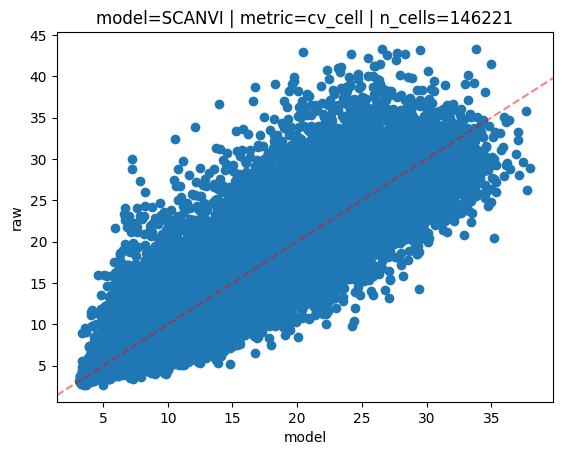

In [8]:
# run ppc for the non latent model
from scvi_hub.criticism import run_ppc, PPC
import math

n_samples = 5
n_indices = math.floor(adata.n_obs/4)

sp = run_ppc(adata, model, "cv_cell", n_samples = n_samples, n_indices=n_indices)

model=SCANVI | metric=cv_cell | n_cells=146221: Mean Absolute Error=1.32, Mean Squared Error=4.22


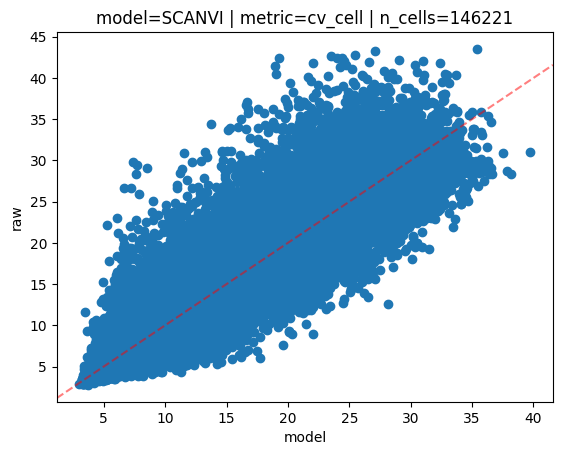

In [9]:
# run ppc for the latent model
sp_latent = run_ppc(adata, model_latent, "cv_cell", n_samples = n_samples, n_indices=n_indices)

TODO figure 8: https://www.nature.com/articles/s41592-018-0229-2/figures/11  
TODO violin maybe: https://www.nature.com/articles/s41592-020-01050-x/figures/6

## 3️⃣ Goodness of fit with PPC + DE

In [38]:
# run DE for the non latent model
adata_de = adata.copy()
adata_de.layers["counts"] = adata_de.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata_de)

import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
    sc.tl.rank_genes_groups(adata_de, 'scanvi_label', use_raw=False, method="t-test")

In [39]:
# get the N highly scored genes from the DE result on the full adata
rgg = adata_de.uns["rank_genes_groups"]
rgg_scores = pd.DataFrame.from_records(rgg["scores"])
rgg_names = pd.DataFrame.from_records(rgg["names"])
n_genes = 2

var_names = {}
for group in rgg_names.columns:
    var_names[group] = adata_de.var.loc[rgg_names[group].values[:n_genes]]["gene_names"].values.tolist()

In [40]:
var_names

{'AT1': ['EMP2', 'AGER'],
 'AT2': ['SFTPB', 'SFTPC'],
 'Arterial EC': ['IFITM3', 'CLDN5'],
 'B cell lineage': ['CD79A', 'CXCR4'],
 'Basal': ['KRT19', 'PERP'],
 'Bronchial Vessel 1': ['SPARCL1', 'GNG11'],
 'Bronchial Vessel 2': ['TM4SF1', 'IFI27'],
 'Capillary': ['RAMP2', 'CLDN5'],
 'Ciliated': ['C20orf85', 'C9orf24'],
 'Dendritic cells': ['HLA-DRA', 'HLA-DPB1'],
 'Fibroblast lineage': ['DCN', 'CALD1'],
 'KRT5- KRT17+ epithelial': ['KRT7', 'TM4SF1'],
 'Lymphatic EC': ['CCL21', 'IGFBP7'],
 'Macrophages': ['TYROBP', 'FCER1G'],
 'Mast cells': ['TPSAB1', 'TPSB2'],
 'Megakaryocytes': ['VIM', 'CTSS'],
 'Mesothelium': ['IFITM3', 'TIMP1'],
 'Monocytes': ['TYROBP', 'SRGN'],
 'Neutrophilic': ['TNFSF13B', 'RASSF2'],
 'Non-T/B cells': ['NKG7', 'GNLY'],
 'Proliferating cells': ['STMN1', 'HMGB2'],
 'Rare': ['CD24', 'KRT18'],
 'Secretory': ['WFDC2', 'SLPI'],
 'Smooth Muscle': ['TAGLN', 'ACTA2'],
 'Squamous': ['CEACAM5', 'LCN2'],
 'Submucosal Secretory': ['SLPI', 'FXYD3'],
 'T cell lineage': ['IL32', '

Let's plot the LFC dotplots.

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


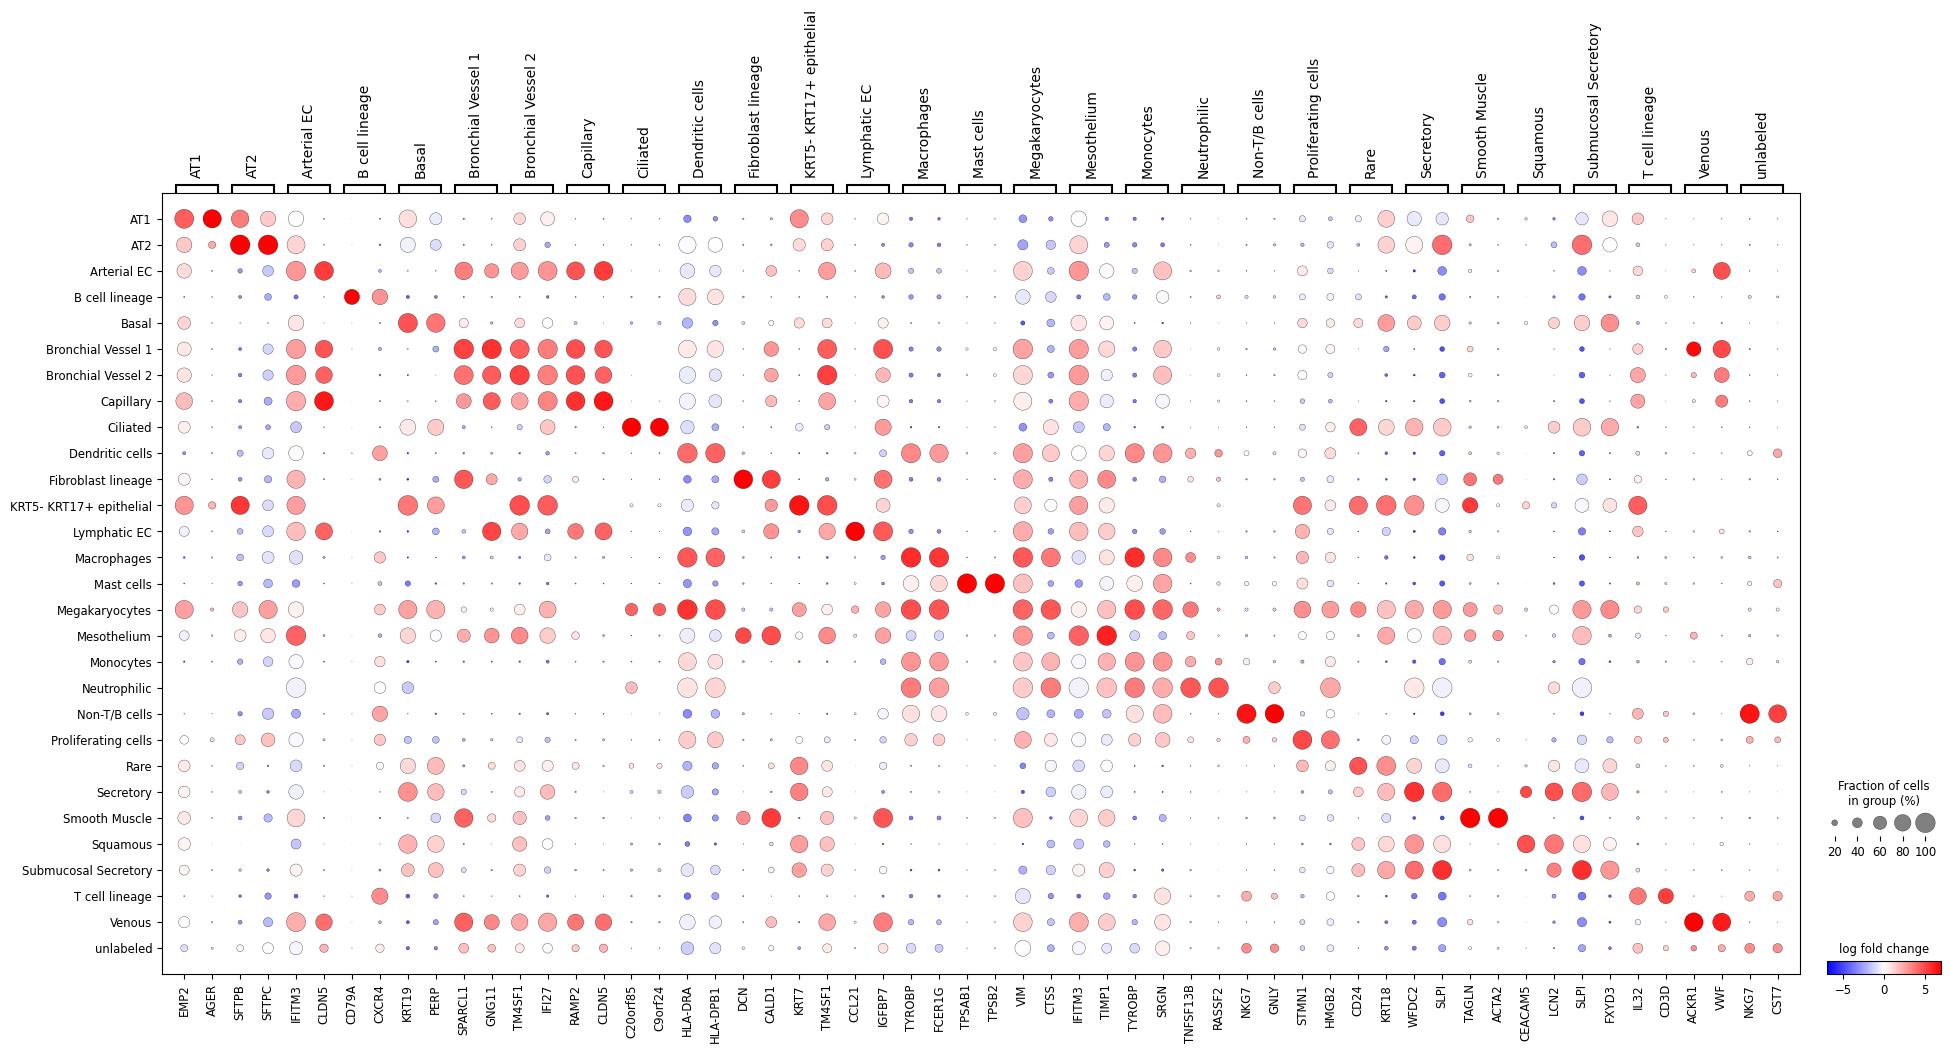

In [12]:
sc.pl.rank_genes_groups_dotplot(
    adata_de,
    values_to_plot='logfoldchanges',
    # min_logfoldchange=3,
    vmax=7,
    vmin=-7,
    cmap='bwr',
    dendrogram=False,
    gene_symbols="gene_names",
    var_names=var_names,
)

In [41]:
# get pp samples for adata_de_latent
from scipy.sparse import csr_matrix
x_hat = model_latent.posterior_predictive_sample()

adata_de_latent = model_latent.adata.copy()
adata_de_latent.X = csr_matrix(x_hat)
sc.pp.normalize_total(adata_de_latent, target_sum=1e4)
sc.pp.log1p(adata_de_latent)

In [42]:
# run DE for the latent model
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
    sc.tl.rank_genes_groups(adata_de_latent, 'scanvi_label', use_raw=False, method="t-test")

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


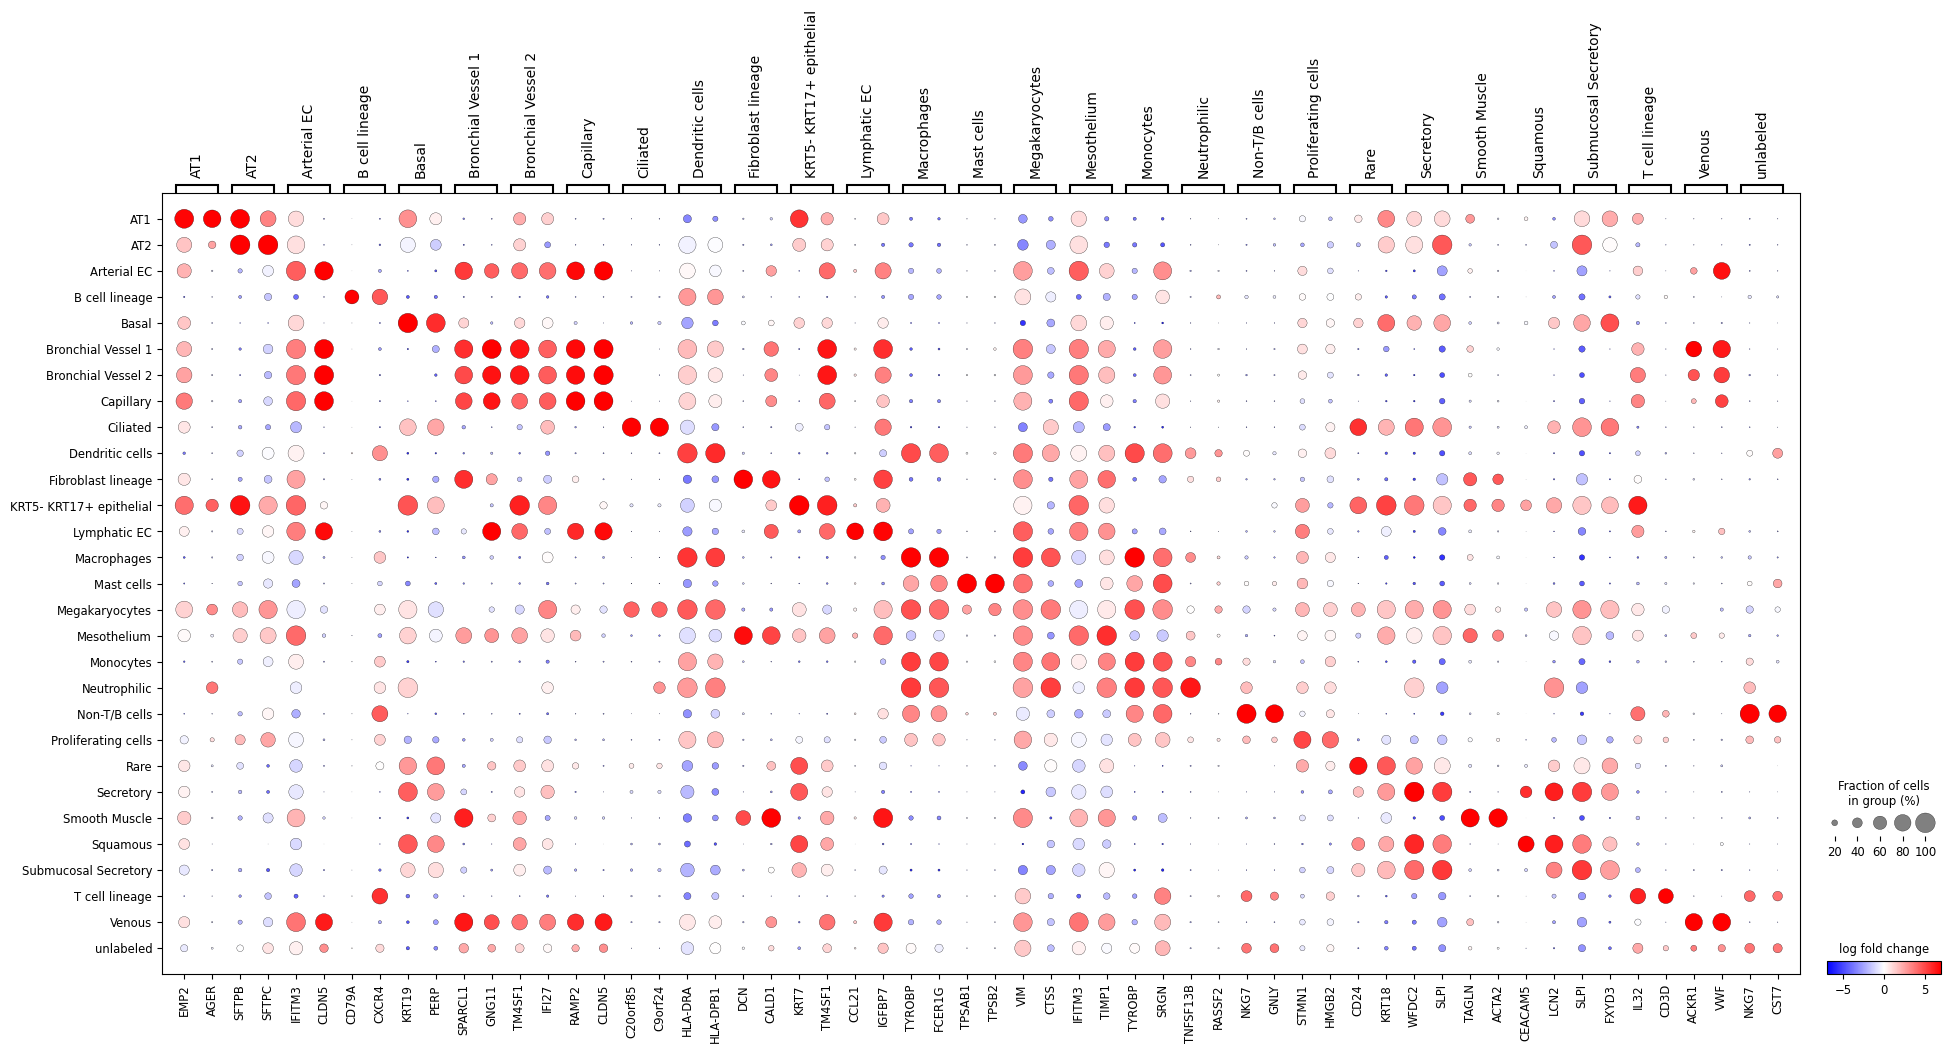

In [19]:
# plot, using N highly scored genes from the DE result on the full adata
# we do this because the N highly scored genes (per group) in the latent data are not the same as the full data. we
# evaluate this discrepancy more later on
sc.pl.rank_genes_groups_dotplot(
    adata_de_latent,
    values_to_plot='logfoldchanges',
    # min_logfoldchange=3,
    vmax=7,
    vmin=-7,
    cmap='bwr',
    dendrogram=False,
    gene_symbols="gene_names",
    var_names=var_names,
)

For better visualization let's plot smaller LFC dotplots, subsetted to immune cell types.

In [22]:
immune_types = [
    "B cell lineage",
    "Dendritic cells",
    "Macrophages",
    "Mast cells",
    "Monocytes",
    "Neutrophilic",
    "T cell lineage"
]

var_names_subset = {k:v for k,v in var_names.items() if k in immune_types}
var_names_subset

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


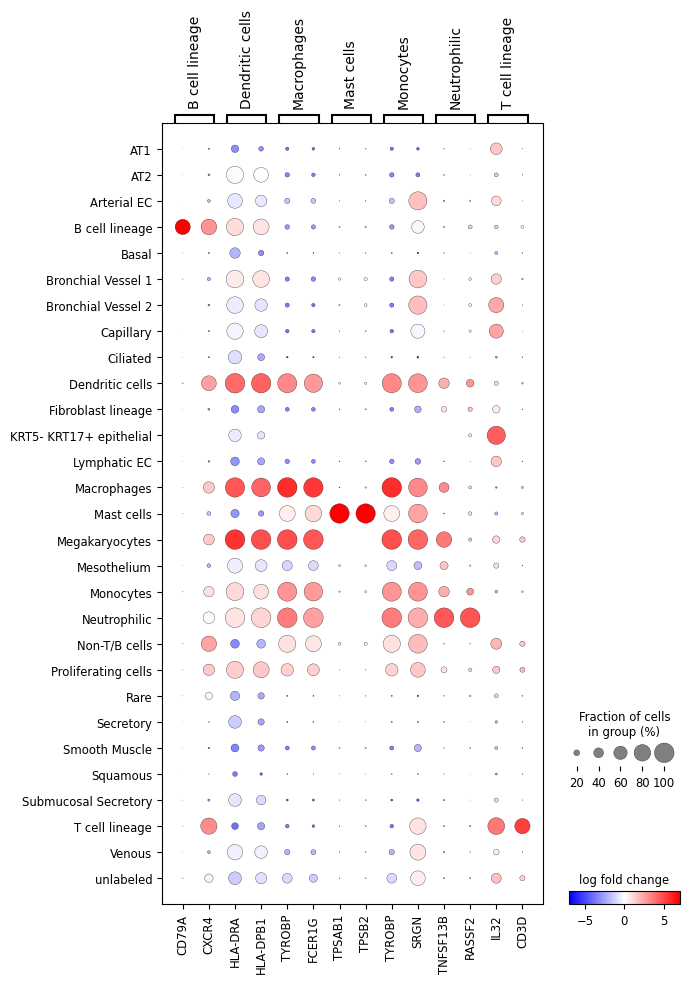

In [34]:
sc.pl.rank_genes_groups_dotplot(
    adata_de,
    values_to_plot='logfoldchanges',
    # min_logfoldchange=3,
    vmax=7,
    vmin=-7,
    cmap='bwr',
    dendrogram=False,
    gene_symbols="gene_names",
    var_names=var_names_subset,
)

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


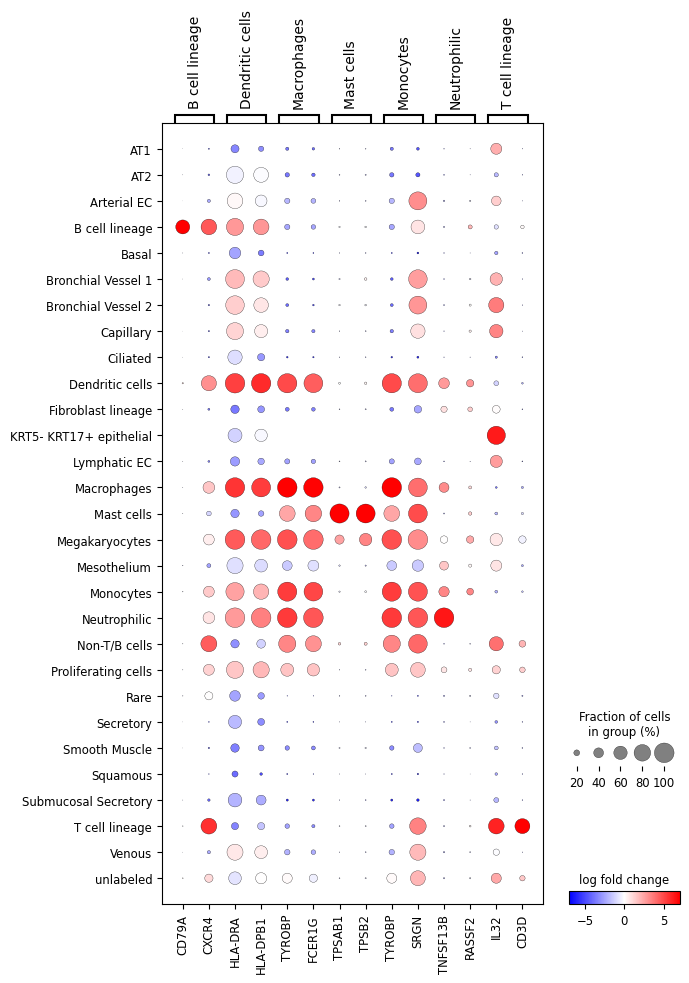

In [33]:
sc.pl.rank_genes_groups_dotplot(
    adata_de_latent,
    values_to_plot='logfoldchanges',
    # min_logfoldchange=3,
    vmax=7,
    vmin=-7,
    cmap='bwr',
    dendrogram=False,
    gene_symbols="gene_names",
    var_names=var_names_subset,
)

To compare these dotplots, I'm going to create two dataframes. One contains the group-wise DE metric for each gene where DE metric is defined as fration of cells in group * lfc. This gives, for each group, a vector where each value corresponds to a gene, and is the "summary" of the expression and lfc of that gene.  
Then:
1. We can compute the (group-wise) L2 distance of these vectors between the latent and non-latent DE results. 
2. We can cmpute the mean across groups of these L2 distances
3. We can  plot for each group a scatter plot where each point is a gene and x is the combined metric (expression * lfc) defined above, for th full DE and y is the same thing for the latent DE 

In [43]:
rgg_latent_dp = sc.pl.rank_genes_groups_dotplot(
    adata_de_latent,
    values_to_plot='logfoldchanges',
    # min_logfoldchange=3,
    vmax=7,
    vmin=-7,
    cmap='bwr',
    dendrogram=False,
    gene_symbols="gene_names",
    var_names=var_names,
    return_fig=True,
)

In [44]:
rgg_dp = sc.pl.rank_genes_groups_dotplot(
    adata_de,
    values_to_plot='logfoldchanges',
    # min_logfoldchange=3,
    vmax=7,
    vmin=-7,
    cmap='bwr',
    dendrogram=False,
    gene_symbols="gene_names",
    var_names=var_names,
    return_fig=True,
)

In [45]:
def calc_dp_metrics(dp, kind: str="lfc"):
    fractions = dp.dot_size_df
    lfc = dp.dot_color_df
    assert fractions.columns.equals(lfc.columns) 
    assert fractions.index.equals(lfc.index)
    if kind == "lfc":
        return lfc
    elif kind == "fractions":
        return fractions
    else:
        raise ValueError(f"Unknown kind: {kind}")

In [46]:
dp_metrics_latent = calc_dp_metrics(rgg_latent_dp)
dp_metrics = calc_dp_metrics(rgg_dp)

`dp_metrics_latent` and `dp_metrics` now represent the dataframes that I described further above.  
Let's compute the L2 distances now (aka MSE i.e. mean square error).

In [47]:
def get_dp_metrics_mae(dp_metrics_1, dp_metrics_2):
    # returns a tuple with:
    # 1. the row-wise mean absolute error between the two dp_metrics
    # 2. the mean of the mean absolute errors across all rows
    dp_diff = dp_metrics_1 - dp_metrics_2
    mae = np.abs(dp_diff).mean(axis=1)
    return mae, np.mean(mae)

In [48]:
mae, mae_mean = get_dp_metrics_mae(dp_metrics_latent, dp_metrics)

Now do the same with correlation coefficient (e.g. pearson) instead of MAE:

In [49]:
def get_dp_metrics_corr_coeff(dp_metrics_1, dp_metrics_2, corr_coeff: str):
    # returns a tuple with:
    # 1. the row-wise correlation coefficient (pearson or spearman) between the two dp_metrics
    # 2. the mean of the correlation coefficients across all rows
    assert dp_metrics_1.index.equals(dp_metrics_2.index)
    assert dp_metrics_1.columns.equals(dp_metrics_2.columns)
    # some genes belong to more than one group (i.e. are markers for more than one group)
    # in this case dp_metrics_1 (and same for dp_metrics_2) will have two or more columns
    # with exactly the same values. Remove those duplicates before computing the correlation.
    x = dp_metrics_1.loc[:, ~dp_metrics_1.columns.duplicated()]
    y = dp_metrics_2.loc[:, ~dp_metrics_2.columns.duplicated()]
    cc_df = pd.Series(index=dp_metrics_1.index, dtype="float64")
    for r in dp_metrics_1.index:
        if corr_coeff == "pearson":
            cc_df[r] = scipy.stats.pearsonr(x.loc[r], y.loc[r])[0]
        elif corr_coeff == "spearman":
            cc_df[r] = scipy.stats.spearmanr(x.loc[r], y.loc[r])[0]
        else:
            raise ValueError(f"Unknown corr_coeff option: {corr_coeff}")
    return cc_df, np.mean(cc_df)

In [50]:
pearson, pearson_mean = get_dp_metrics_corr_coeff(dp_metrics_latent, dp_metrics, "pearson")
spearman, spearman_mean = get_dp_metrics_corr_coeff(dp_metrics_latent, dp_metrics, "spearman")

In [51]:
print(f"pearson_mean: {pearson_mean}, spearman_mean: {spearman_mean}, mae_mean: {mae_mean}")
# print(f"mse:\n{mse}")

pearson_mean: 0.923970239506389, spearman_mean: 0.9563703165065637, mae_mean: 1.1809803247451782


Now let's view scatterplots for each group with per-group mse, peasonr, spearmanr, etc. computed above.

In [52]:
# from https://stackoverflow.com/a/28216751
def add_identity(axes, *line_args, **line_kwargs):
    (identity,) = axes.plot([], [], *line_args, **line_kwargs)

    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])

    callback(axes)
    axes.callbacks.connect("xlim_changed", callback)
    axes.callbacks.connect("ylim_changed", callback)
    return axes

In [50]:
def plot_all_across_groups(title: str, dp_metrics_1, dp_metrics_2, pearson: pd.Series, spearman: pd.Series, mae: pd.Series):
    # https://engineeringfordatascience.com/posts/matplotlib_subplots/
    # define subplot grid
    figsize = (20., 20.,)
    fig, axs = plt.subplots(nrows=8, ncols=4, figsize=figsize)
    plt.subplots_adjust(hspace=1)
    fig.suptitle(title, fontsize=18, y=0.95)
    axs_lst = axs.ravel()
    # plot all
    i = 0
    for group in dp_metrics_1.index:
        ax = axs_lst[i]
        i += 1
        full = dp_metrics_1.loc[group]
        latent = dp_metrics_2.loc[group]
        ax.scatter(full, latent)
        add_identity(ax, color="r", ls="--", alpha=0.5)
        ax.set_title(f"{group} \n pearson={pearson[group]:.2f} - spearman={spearman[group]:.2f} - mae={mae[group]:.2f}")
    plt.show()

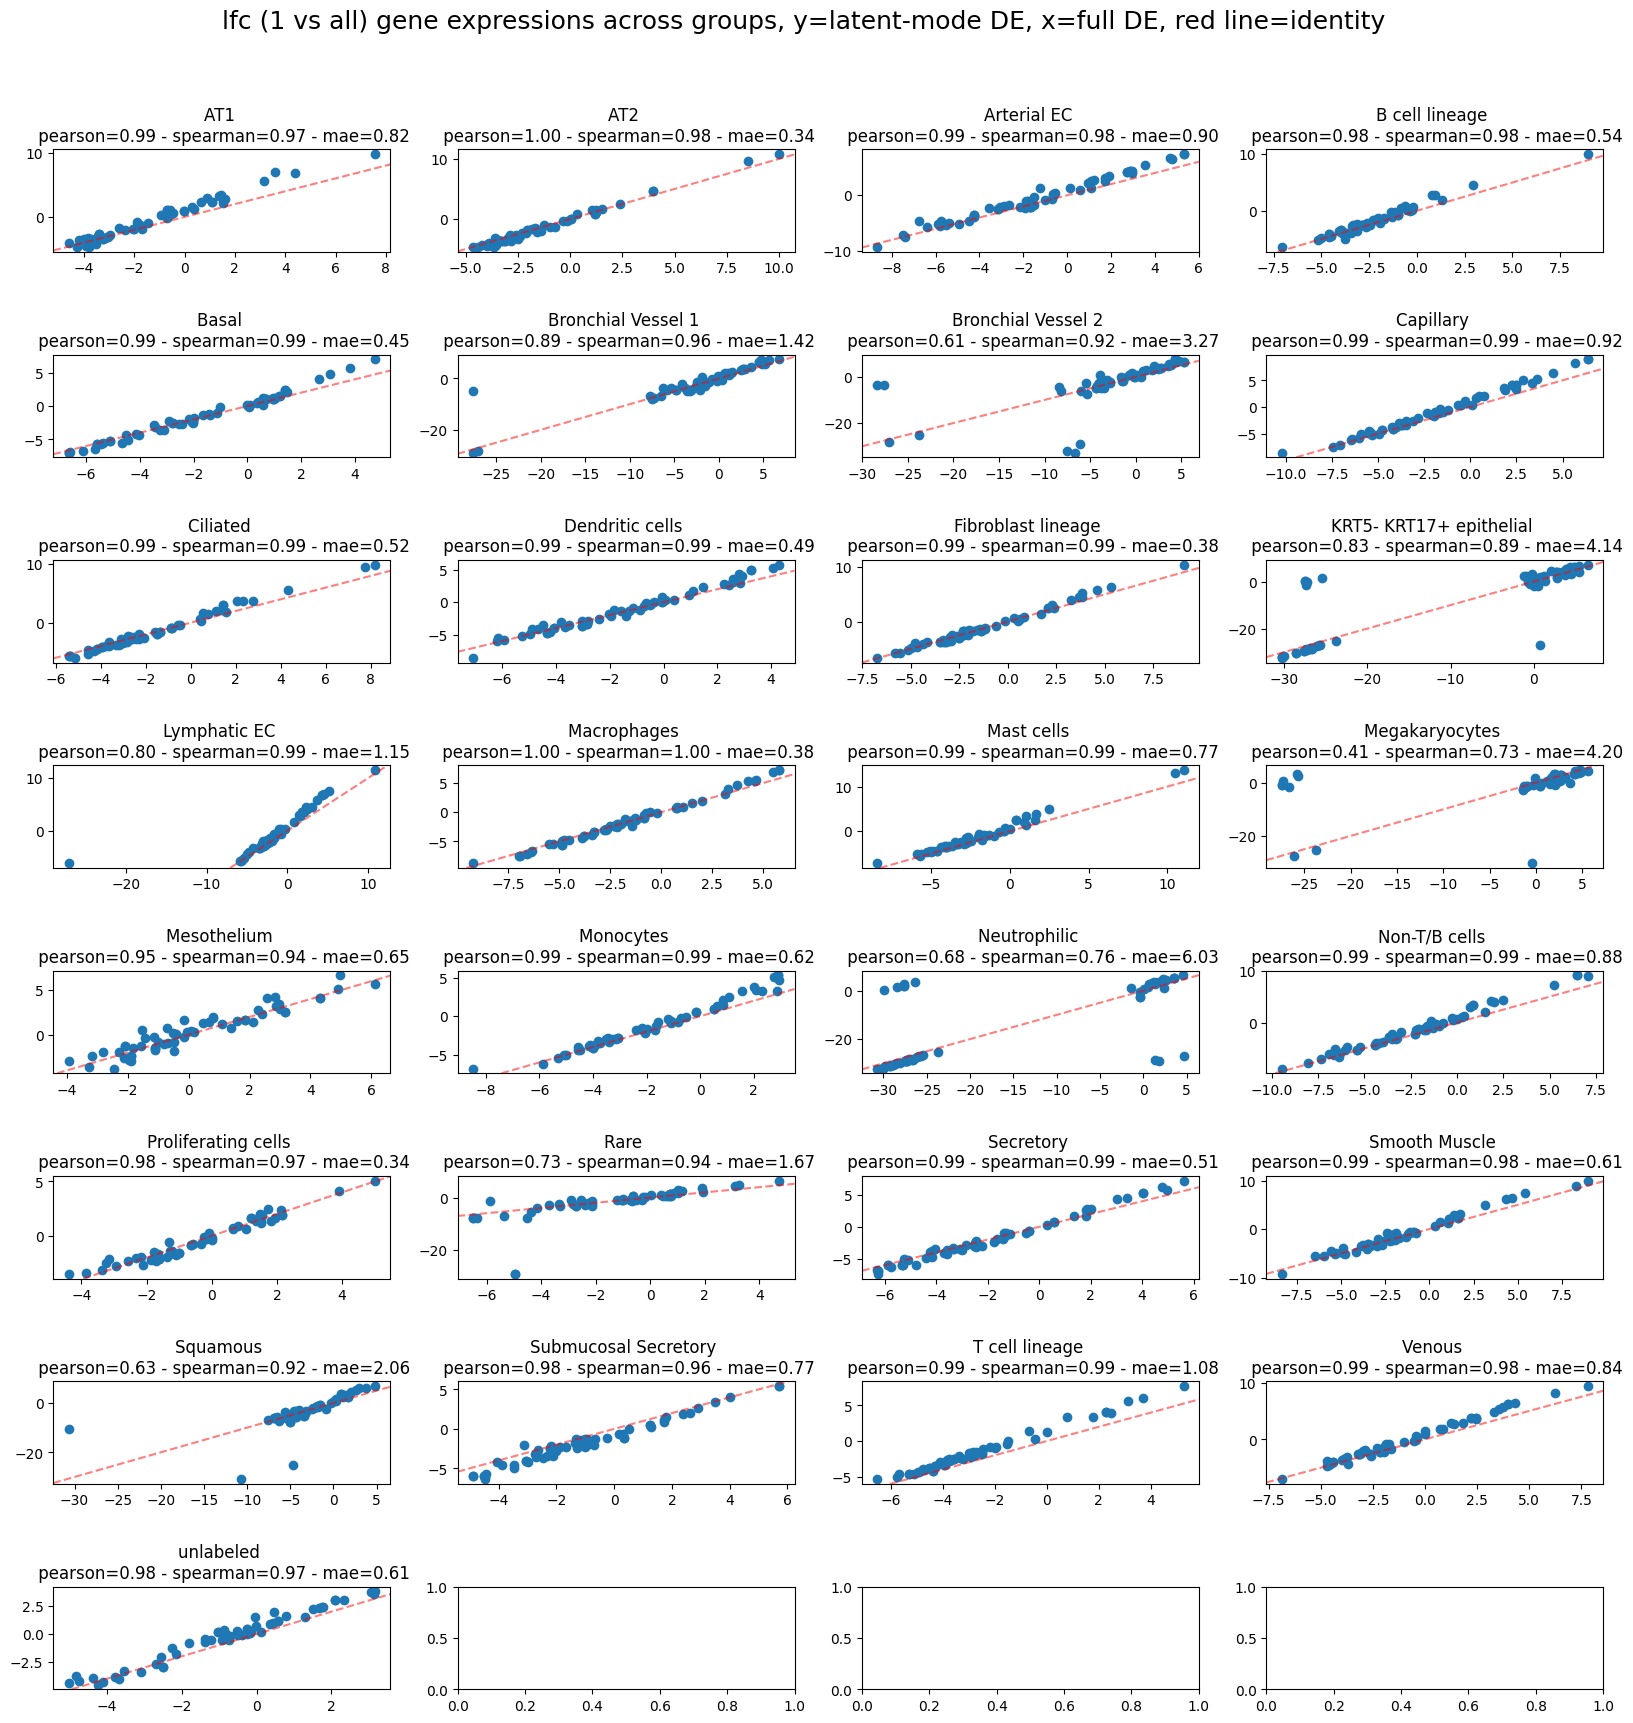

In [51]:
title = "lfc (1 vs all) gene expressions across groups, y=latent-mode DE, x=full DE, red line=identity"
plot_all_across_groups(title, dp_metrics, dp_metrics_latent, pearson, spearman, mae)

Now do the same as above but using cell fractions instead of lfc.

In [53]:
dp_metrics_latent_frac = calc_dp_metrics(rgg_latent_dp, kind="fractions")
dp_metrics_frac = calc_dp_metrics(rgg_dp, kind="fractions")
mae_frac, mae_mean_frac = get_dp_metrics_mae(dp_metrics_latent_frac, dp_metrics_frac)
pearson_frac, pearson_mean_frac = get_dp_metrics_corr_coeff(dp_metrics_latent_frac, dp_metrics_frac, "pearson")
spearman_frac, spearman_mean_frac = get_dp_metrics_corr_coeff(dp_metrics_latent_frac, dp_metrics_frac, "spearman")
print(f"pearson_mean: {pearson_mean_frac}, spearman_mean: {spearman_mean_frac}, mae_mean: {mae_mean_frac}")

pearson_mean: 0.9805402472643042, spearman_mean: 0.9727634634045493, mae_mean: 0.030171942024813547


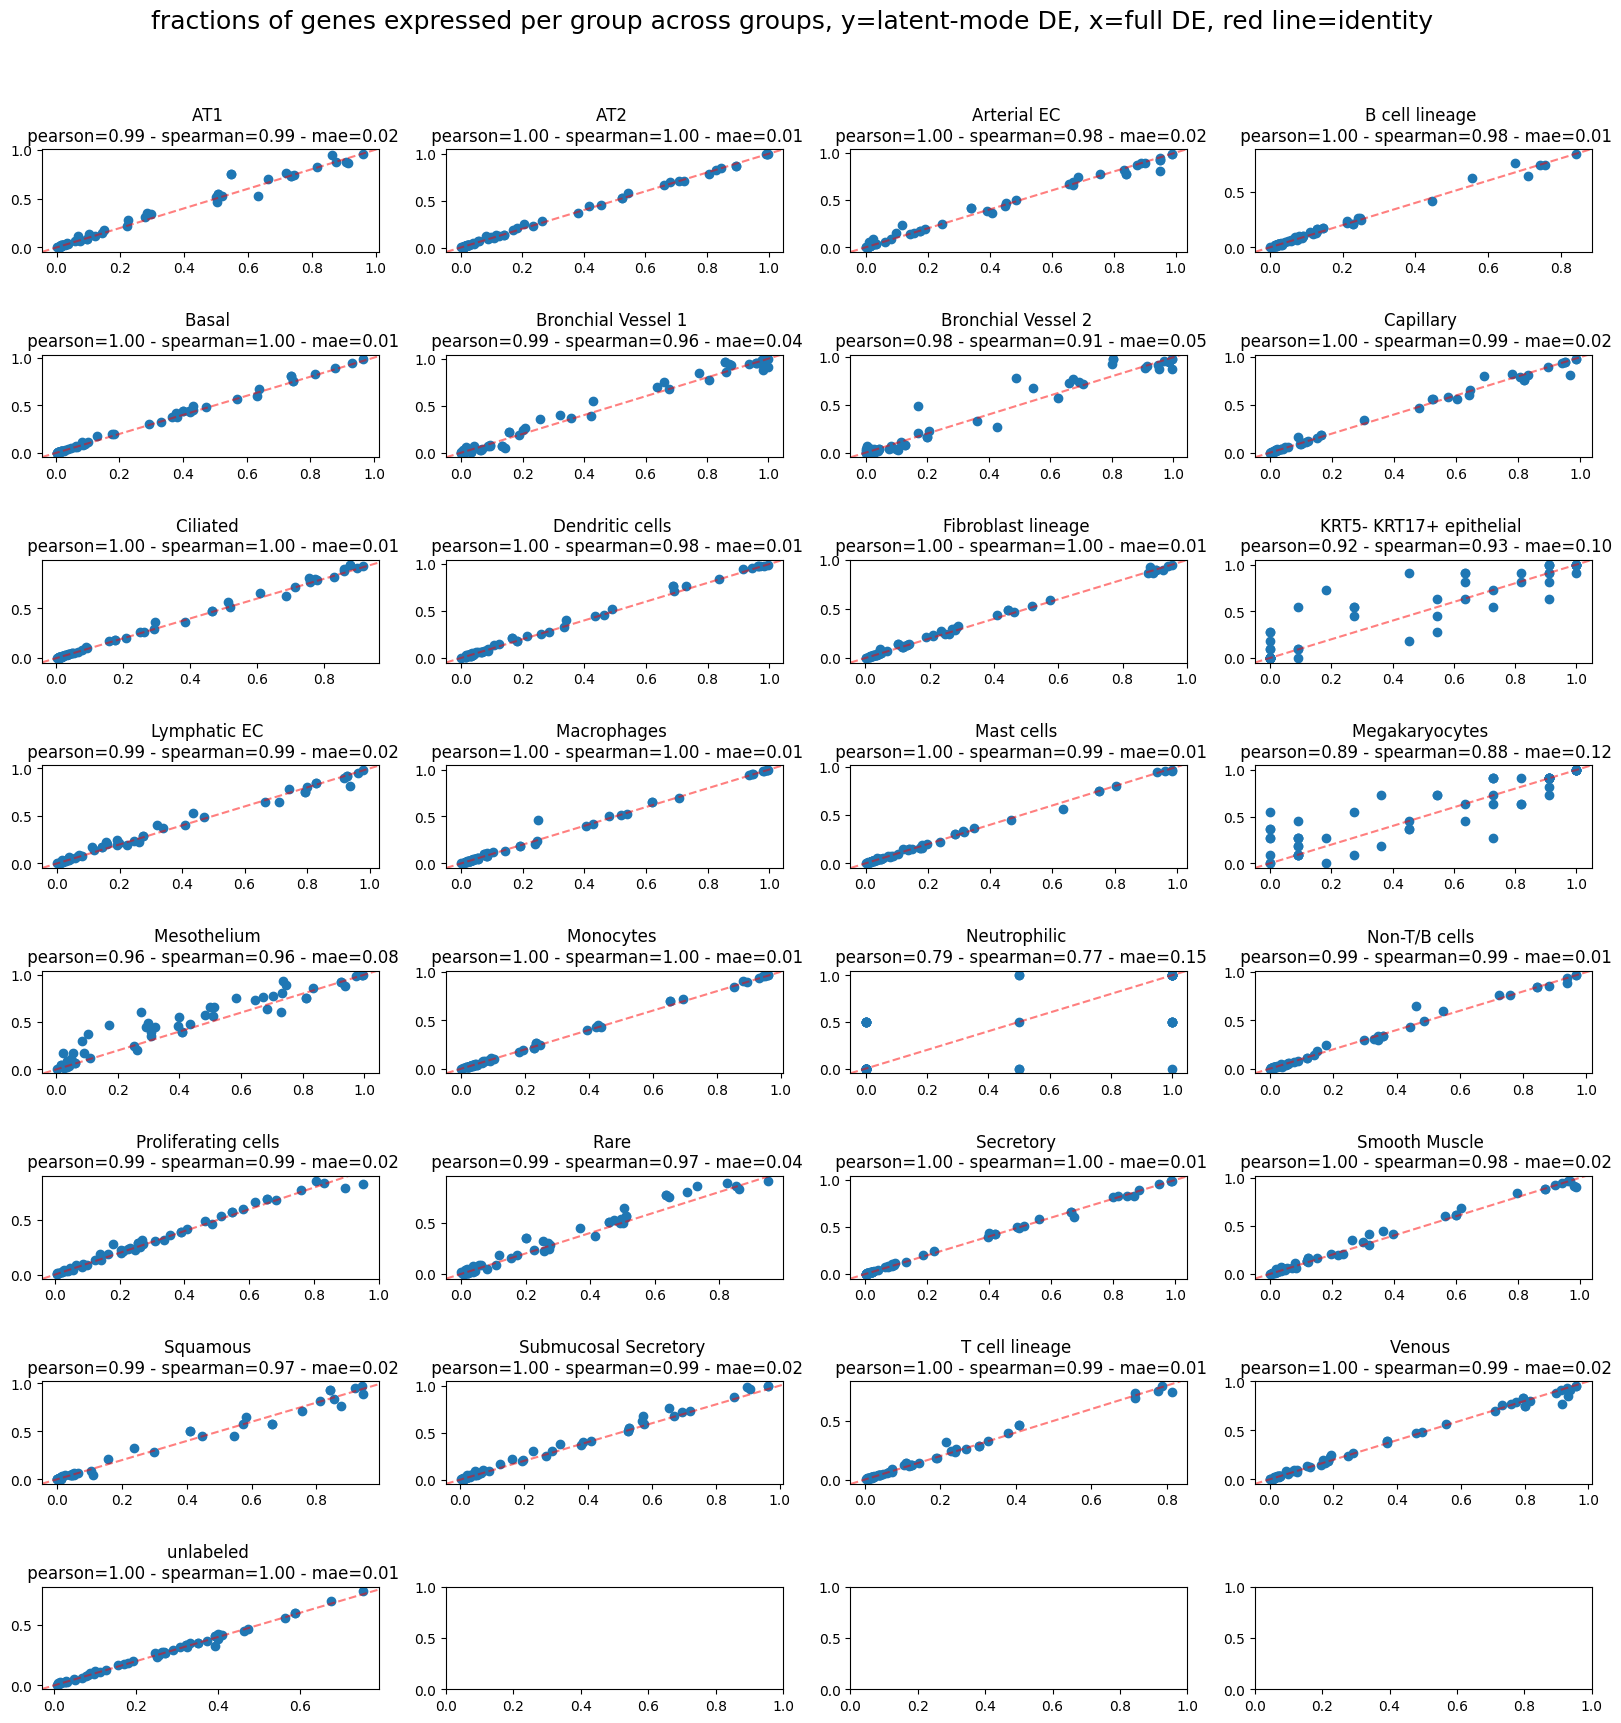

In [53]:
title = "fractions of genes expressed per group across groups, y=latent-mode DE, x=full DE, red line=identity"
plot_all_across_groups(title, dp_metrics_frac, dp_metrics_latent_frac, pearson_frac, spearman_frac, mae_frac)

Let's look at the ranked gene overlaps between DE results on the full and latent data next.

In [82]:
# th = 0.0005
# df = pd.DataFrame.from_records(rgg_temp["pvals_adj"])
# for group in df.columns:
#     a = df[group][df[group] < th]
#     b = df[group]
#     print(f"{group}: {len(a)}, {len(b)}, {len(a) * 100 / len(b)}")

AT1: 1893, 2000, 94.65
AT2: 1954, 2000, 97.7
Arterial EC: 1866, 2000, 93.3
B cell lineage: 1840, 2000, 92.0
Basal: 1951, 2000, 97.55
Bronchial Vessel 1: 1686, 2000, 84.3
Bronchial Vessel 2: 1647, 2000, 82.35
Capillary: 1941, 2000, 97.05
Ciliated: 1932, 2000, 96.6
Dendritic cells: 1801, 2000, 90.05
Fibroblast lineage: 1908, 2000, 95.4
KRT5- KRT17+ epithelial: 1162, 2000, 58.1
Lymphatic EC: 1834, 2000, 91.7
Macrophages: 1942, 2000, 97.1
Mast cells: 1868, 2000, 93.4
Megakaryocytes: 810, 2000, 40.5
Mesothelium: 1326, 2000, 66.3
Monocytes: 1903, 2000, 95.15
Neutrophilic: 1698, 2000, 84.9
Non-T/B cells: 1872, 2000, 93.6
Proliferating cells: 1573, 2000, 78.65
Rare: 1492, 2000, 74.6
Secretory: 1942, 2000, 97.1
Smooth Muscle: 1820, 2000, 91.0
Squamous: 1830, 2000, 91.5
Submucosal Secretory: 1789, 2000, 89.45
T cell lineage: 1945, 2000, 97.25
Venous: 1873, 2000, 93.65
unlabeled: 1810, 2000, 90.5


In [54]:
def get_all_de_groups():
    # let's just sanity check it's the same for full and latent adata
    f = adata_de.uns["rank_genes_groups"]["names"].dtype.names
    l = adata_de_latent.uns["rank_genes_groups"]["names"].dtype.names
    assert f == l
    return f

def get_top_n_genes_per_group(adata, n_genes: int):
    rgg = adata.uns["rank_genes_groups"]
    rgg_names = pd.DataFrame.from_records(rgg["names"])
    group_to_genes = {}
    for group in rgg_names.columns:
        top_n_gene_ids = rgg_names[group].values[:n_genes]
        top_n_gene_names = adata_de.var.loc[top_n_gene_ids]["gene_names"]
        group_to_genes[group] = top_n_gene_names.values.tolist()
    return group_to_genes

# def get_all_genes_per_group_by_pval_threshold(adata, pval_threshold: float):
#     rgg = adata.uns["rank_genes_groups"]
#     rgg_pvals_adj = pd.DataFrame.from_records(rgg["pvals_adj"])
#     group_to_genes = {}
#     for group in rgg_names.columns:
#         top_n_gene_ids = rgg_names[group].values[:n_genes]
#         top_n_gene_names = adata_de.var.loc[top_n_gene_ids]["gene_names"]
#         group_to_genes[group] = top_n_gene_names.values.tolist()
#     return group_to_genes

def get_precision_recall(ground_truth: np.ndarray, pred: np.ndarray, do_round: bool = True):
    assert type(ground_truth) == np.ndarray and type(pred) == np.ndarray
    # https://stackoverflow.com/a/68157457
    tp = np.sum(np.logical_and(pred == 1, ground_truth == 1))
    fp = np.sum(np.logical_and(pred == 1, ground_truth == 0))
    fn = np.sum(np.logical_and(pred == 0, ground_truth == 1))
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    if precision == 0 and recall == 0:
        f1 = 0
    else:
        f1 = (2*precision*recall) / (precision+recall)
    if do_round:
        dec = 2
        return np.round(precision, dec), np.round(recall, dec), np.round(f1, dec)
    else:
        return precision, recall, f1

def get_binary_array_from_selected_genes(selected_genes) -> np.ndarray:
    assert np.all(adata_de.var.gene_names == adata_de_latent.var.gene_names)
    all_genes = adata_de.var.gene_names
    v = [0 if g not in selected_genes else 1 for g in all_genes]
    return np.array(v)

def get_f1_per_n_genes():
    n_genes_list = range(2, 200)
    groups = get_all_de_groups()
    gene_comparisons = {}
    for n_genes in n_genes_list:
        # get the N highly scored genes from the DE result on the full adata and latent data
        top_genes_full = get_top_n_genes_per_group(adata_de, n_genes)
        top_genes_latent = get_top_n_genes_per_group(adata_de_latent, n_genes)
        # get precision/recall while considering the unordered set of top ranked genes between
        # full and latent DE results. We omit order here because our LFC comparisons above (which
        # only use top ranked genes from the full-data DE results) demonstrate decent correlation
        # with the latent-data DE results.
        # To do that we "binarize" the gene selections in that we create two binary vectors (one for
        # full, one for latent) where a 1 in the vector means gene was selected.
        df = pd.DataFrame(index=groups, columns=["precision", "recall", "f1"])
        for g in groups:
            ground_truth = get_binary_array_from_selected_genes(top_genes_full[g])
            pred = get_binary_array_from_selected_genes(top_genes_latent[g])
            assert np.sum(ground_truth) == n_genes and np.sum(pred) == n_genes
            prf = get_precision_recall(ground_truth, pred)
            df.loc[g] = prf[0], prf[1], prf[2]
        gene_comparisons[n_genes] = df
    return gene_comparisons

gene_comparisons = get_f1_per_n_genes()

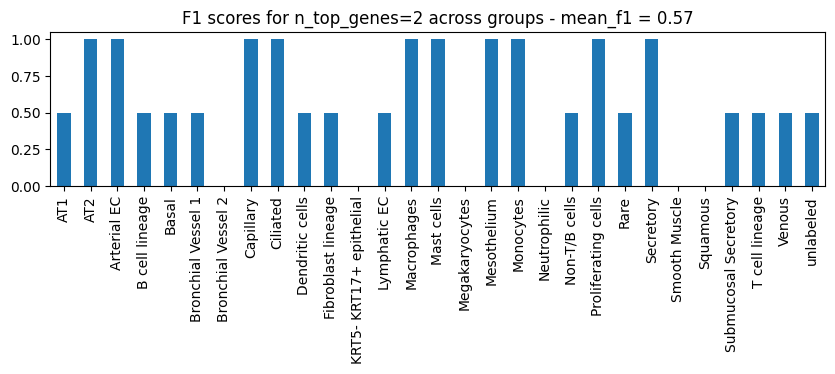

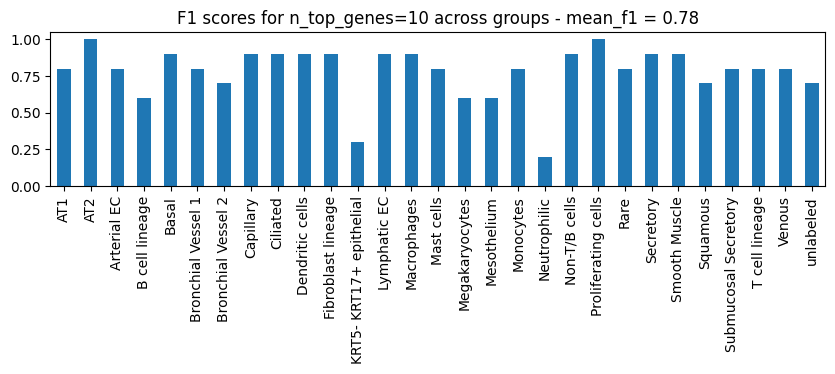

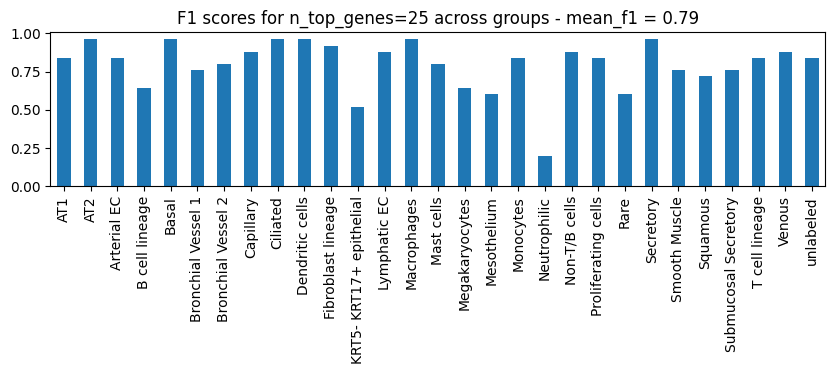

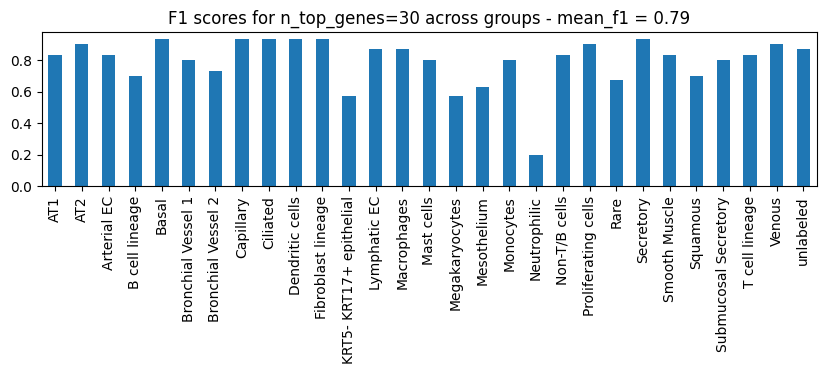

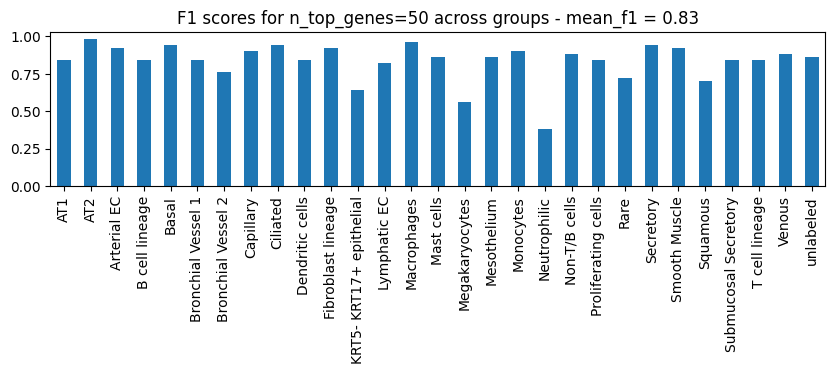

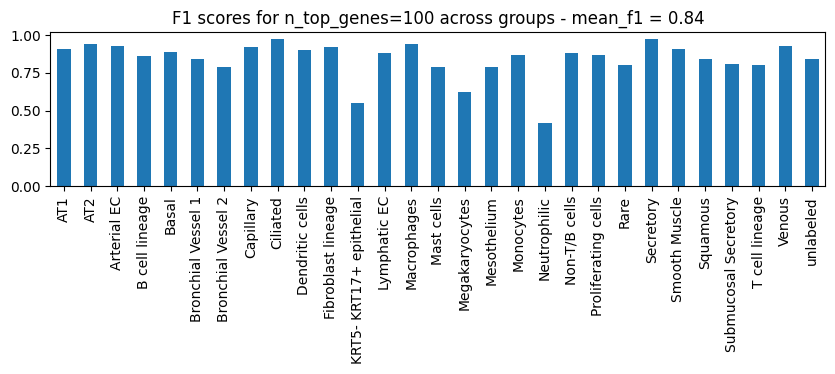

In [106]:
# 1. plot per-group F1 bar plots for some n_genes
# You'll notice that precision, recall and f1 scores are all the same for
# all groups. This is because of how we define these metrics. tp is the intersection
# between A and B which is the same for precision and recall. fp and fn are either A-B
# or B-A but those have the same counts because n_A = n_B. TODO see schematic. Thus we only
# plot F1 scores (also because they recapitulate precision and recall).
n_genes_list_mini = [2, 10, 25, 30, 50, 100]
for n_genes in n_genes_list_mini:
    mean_f1 = np.mean(gene_comparisons[n_genes]["f1"])
    gene_comparisons[n_genes].plot.bar(y="f1", figsize=(10,2),
    title=f"F1 scores for n_top_genes={n_genes} across groups - mean_f1 = {mean_f1:.2f}", legend=False)

<AxesSubplot: title={'center': 'mean F1 score across groups for various n_top_genes'}, xlabel='n_genes', ylabel='mean_f1'>

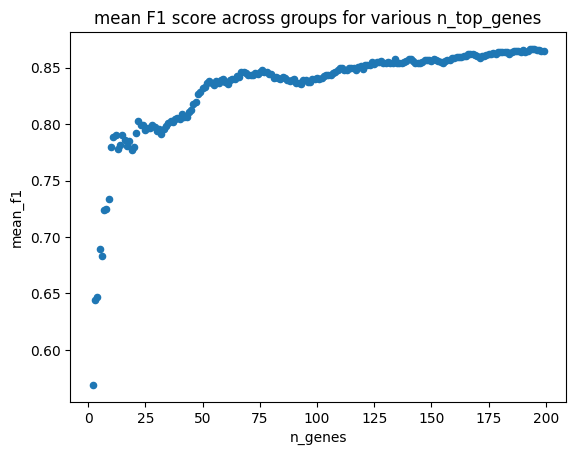

In [107]:
# 2. compute mean F1 scores for each n_genes and plot them on a scatter plot against n_genes
f1_df = pd.DataFrame(index=gene_comparisons.keys(), columns=["mean_f1"])
for n_genes in f1_df.index:
    f1_df.loc[n_genes, "mean_f1"] = np.mean(gene_comparisons[n_genes]["f1"])
f1_df["n_genes"] = f1_df.index
f1_df.plot.scatter(x="n_genes", y="mean_f1", title="mean F1 score across groups for various n_top_genes")

Let's summarize all statistics in one barplot that plots three bars for each group:    

- pearson corr. between full and latent DE gene LFC's
- spearman corr. for the above
- pearson corr. between full and latent DE gene expressivity (i.e. fraction of cells expressing that gene)
- spearman corr. for the abvoe
- F1 score representing overlap between full and latent DE of the top 100 genes

In [70]:
# sanity checking
from itertools import combinations
idxs = []
idxs.append(pearson.index)
idxs.append(spearman.index)
idxs.append(pearson_frac.index)
idxs.append(spearman_frac.index)
idxs.append(gene_comparisons[100]["f1"].index)
for couple in combinations(idxs, 2):
    assert(couple[0].equals(couple[1]))

In [72]:
cols = ["lfc_pearson", "lfc_spearman", "cell_frac_pearson", "cell_frac_spearman", "gene_overlap_f1"]
summary_df = pd.DataFrame(index=pearson.index, columns=cols)
summary_df["lfc_pearson"] = pearson
summary_df["lfc_spearman"] = spearman
summary_df["cell_frac_pearson"] = pearson_frac
summary_df["cell_frac_spearman"] = spearman_frac
summary_df["gene_overlap_f1"] = gene_comparisons[100]["f1"]

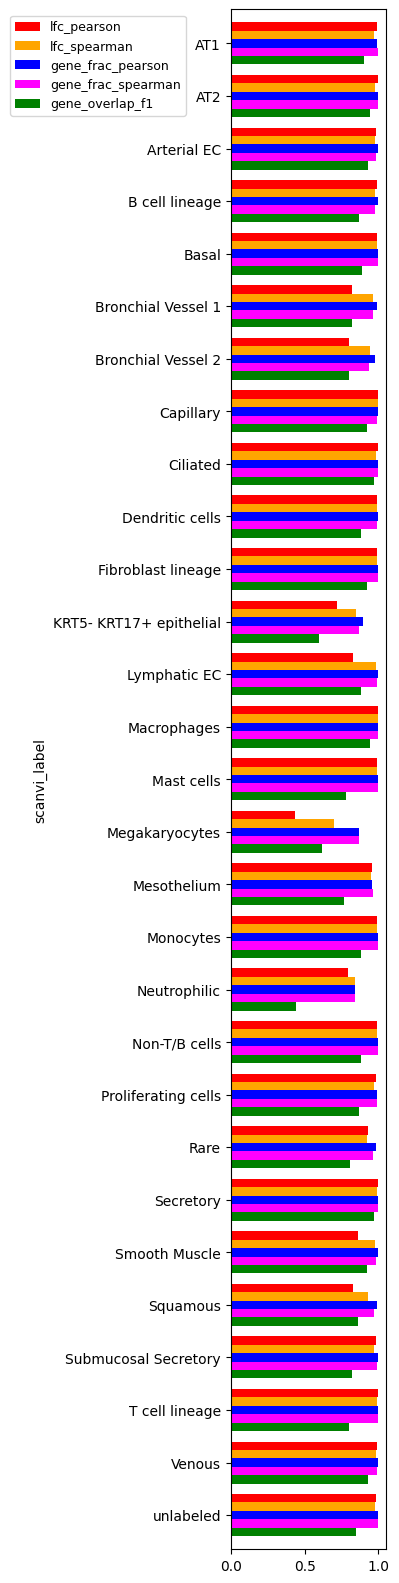

In [137]:
color={
    "lfc_pearson": "red",
    "lfc_spearman": "orange",
    "cell_frac_pearson": "blue",
    "cell_frac_spearman": "magenta",
    "gene_overlap_f1": "green",
}
summary_df.plot.barh(
    figsize=(2,20), width=0.8, color=color
).invert_yaxis()
plt.legend(bbox_to_anchor=(-0.25, 1), fontsize=9)

## ~~4️⃣ Same as 3 but with pvals instead of lfc~~

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


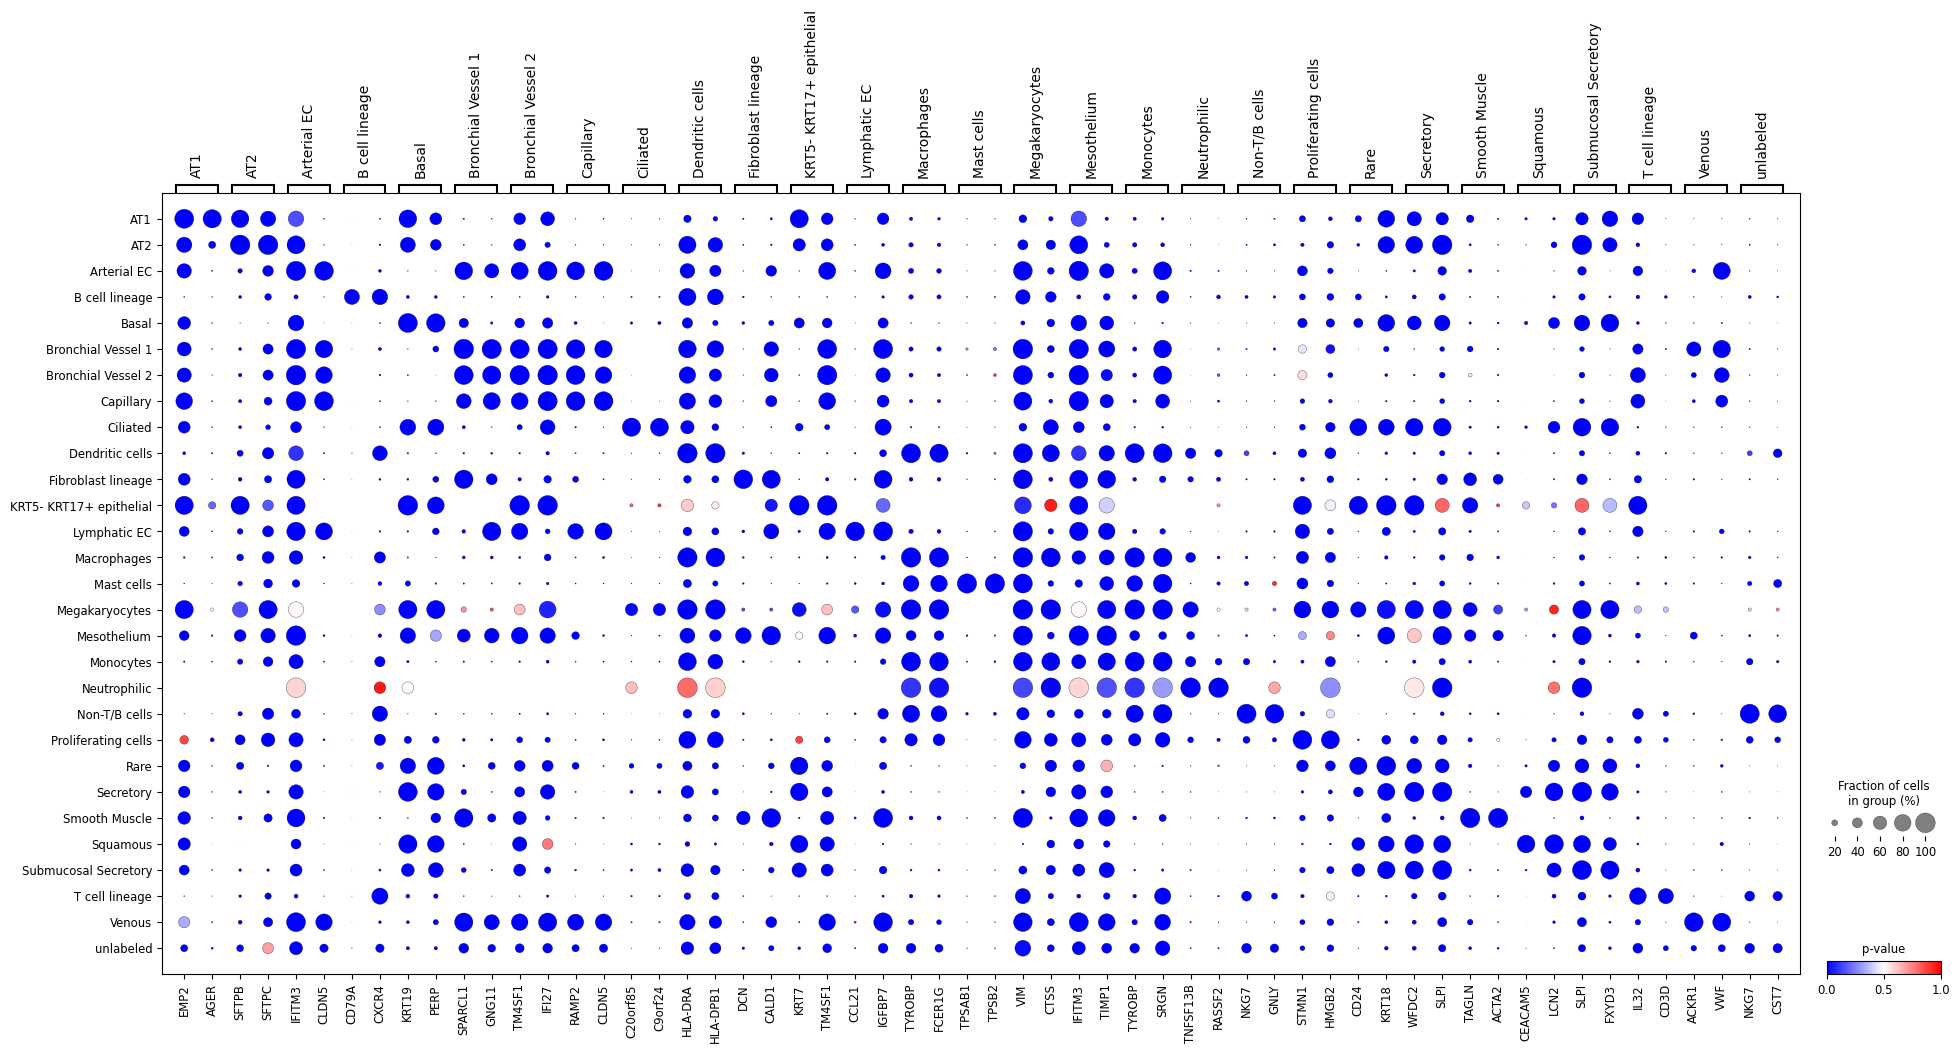

In [223]:
sc.pl.rank_genes_groups_dotplot(
    adata_de,
    values_to_plot='pvals',
    vmax=1,
    vmin=0,
    cmap='bwr',
    dendrogram=False,
    gene_symbols="gene_names",
    var_names=var_names,
)

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


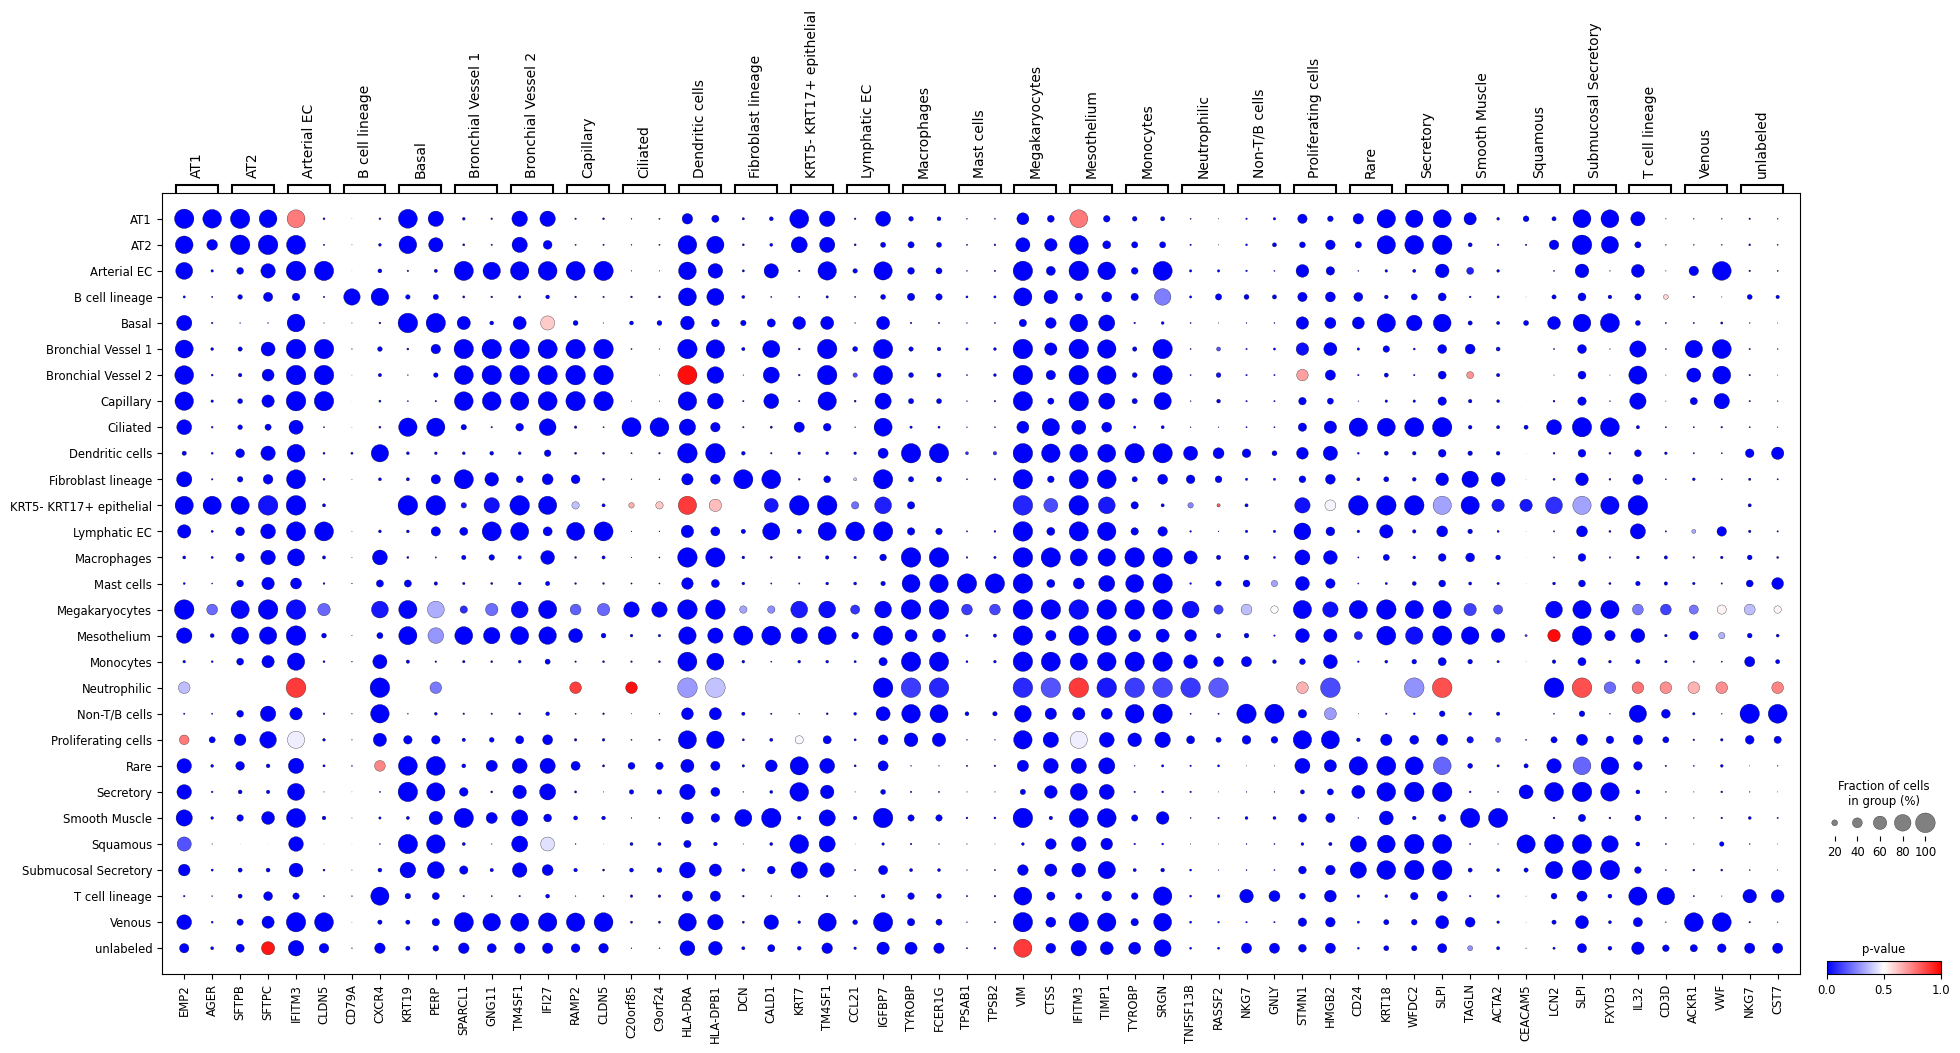

In [224]:
sc.pl.rank_genes_groups_dotplot(
    adata_de_latent,
    values_to_plot='pvals',
    vmax=1,
    vmin=0,
    cmap='bwr',
    dendrogram=False,
    gene_symbols="gene_names",
    var_names=var_names,
)

In [268]:
rgg_latent_dp_pvals = sc.pl.rank_genes_groups_dotplot(
    adata_de_latent,
    values_to_plot='log10_pvals',
    vmax=1,
    vmin=0,
    cmap='bwr',
    dendrogram=False,
    gene_symbols="gene_names",
    var_names=var_names,
    return_fig=True,
)

In [269]:
rgg_dp_pvals = sc.pl.rank_genes_groups_dotplot(
    adata_de,
    values_to_plot='log10_pvals',
    vmax=1,
    vmin=0,
    cmap='bwr',
    dendrogram=False,
    gene_symbols="gene_names",
    var_names=var_names,
    return_fig=True,
)

In [270]:
dp_metrics_latent_pvals = calc_dp_metrics(rgg_latent_dp_pvals)
dp_metrics_pvals = calc_dp_metrics(rgg_dp_pvals)

In [272]:
mse_pvals, mse_mean_pvals = get_dp_metrics_mse(dp_metrics_latent_pvals, dp_metrics_pvals)
pearson_pvals, pearson_mean_pvals = get_dp_metrics_corr_coeff(dp_metrics_latent_pvals, dp_metrics_pvals, "pearson")
spearman_pvals, spearman_mean_pvals = get_dp_metrics_corr_coeff(dp_metrics_latent_pvals, dp_metrics_pvals, "spearman")

In [273]:
spearman_mean_pvals, pearson_mean_pvals, mse_mean_pvals

(0.8455885558865199, 0.658503814927064, 0.3263011229916707)

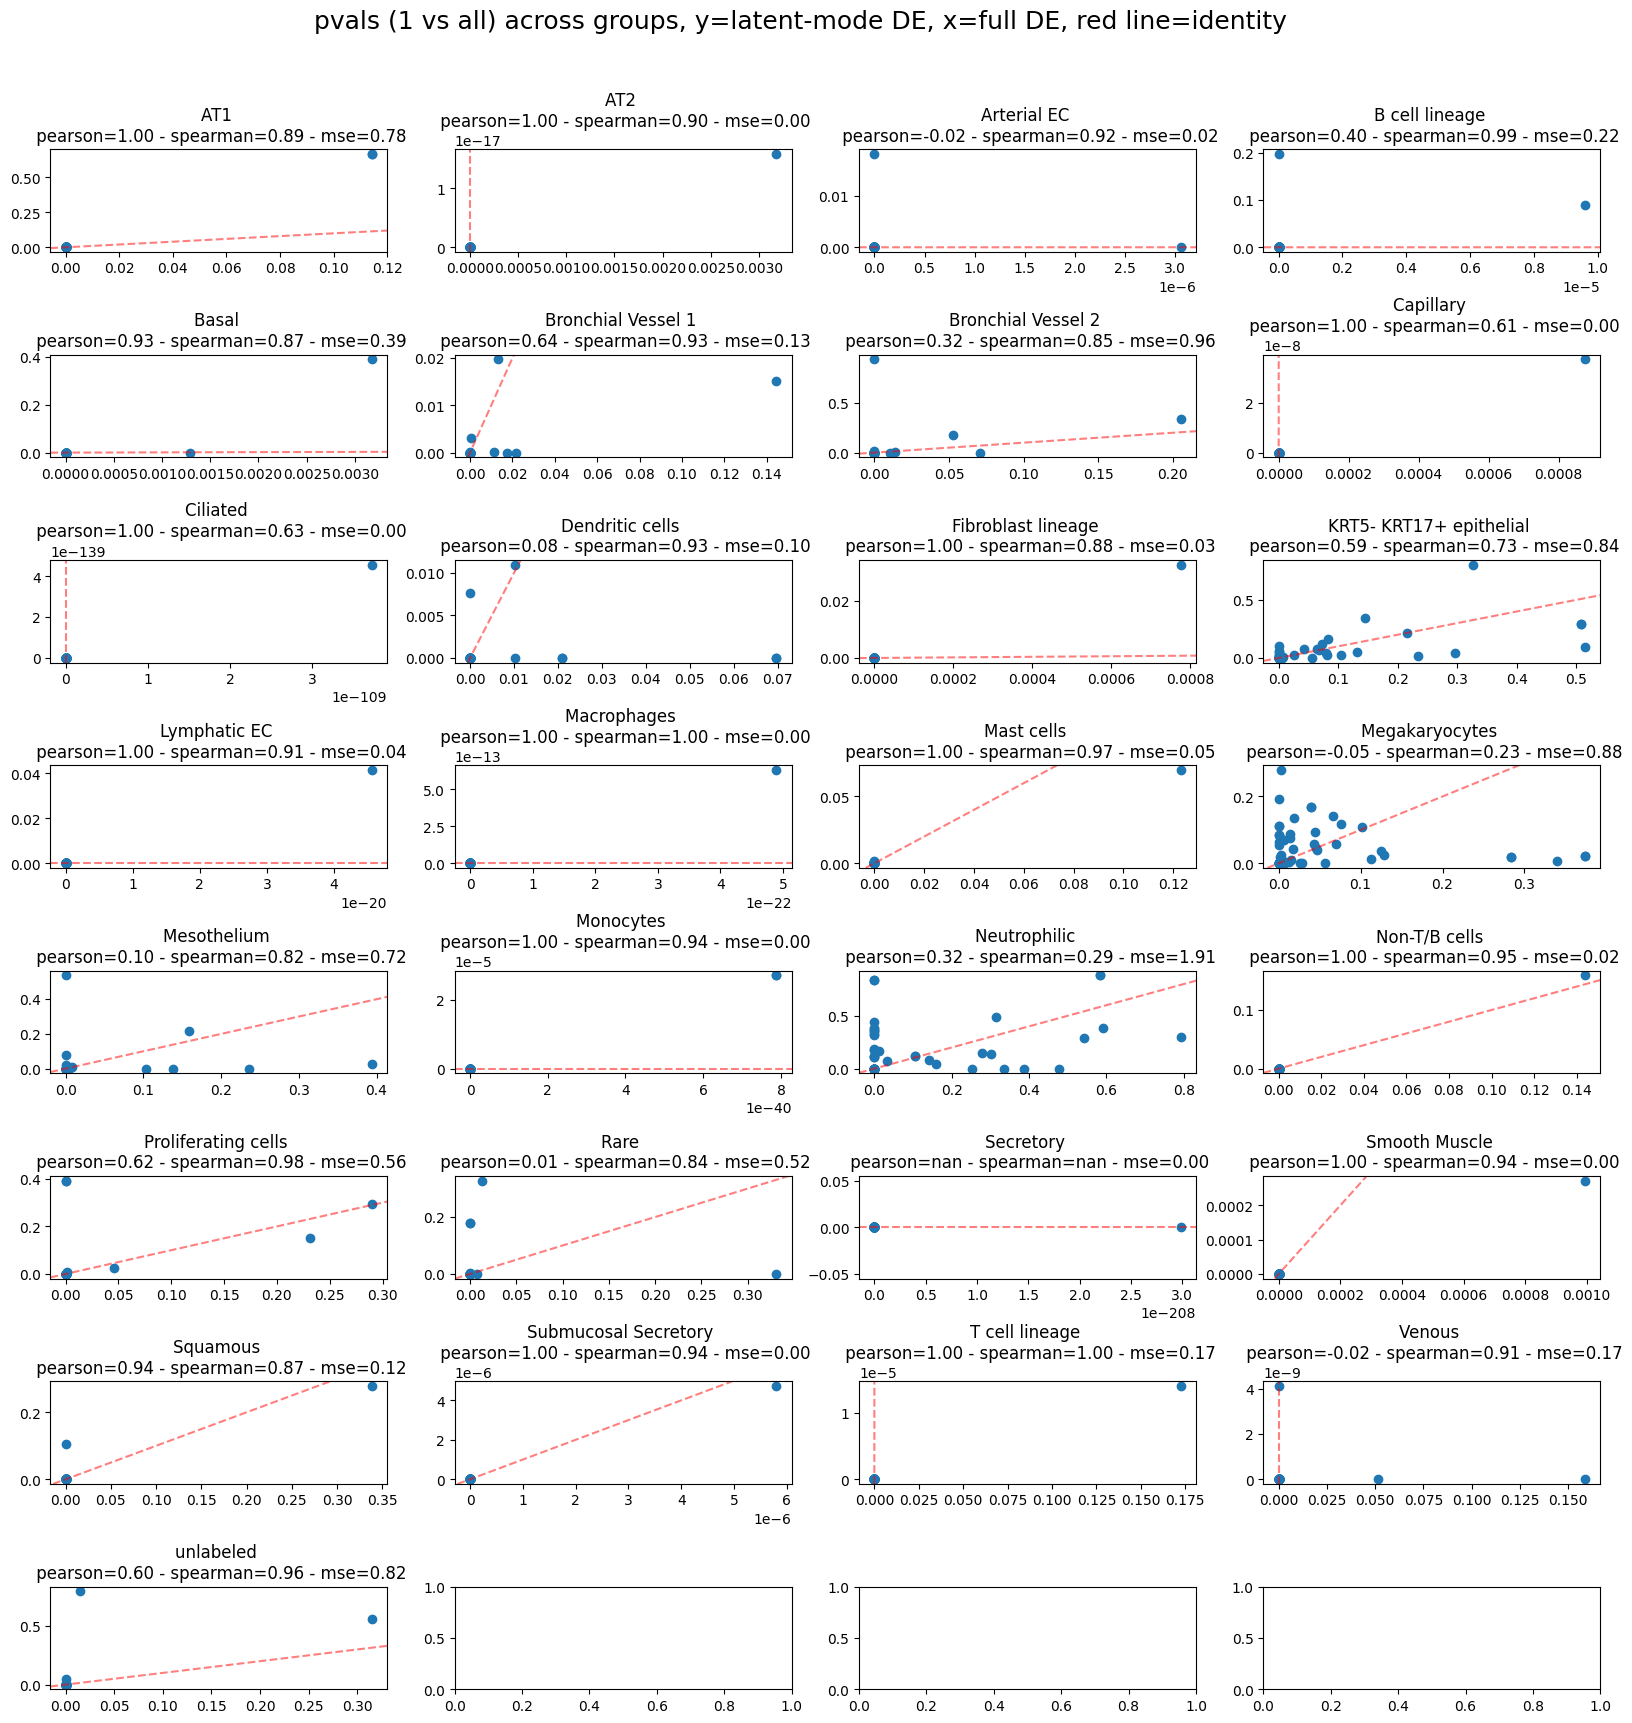

In [274]:
# https://engineeringfordatascience.com/posts/matplotlib_subplots/
# define subplot grid
figsize = (20., 20.,)
fig, axs = plt.subplots(nrows=8, ncols=4, figsize=figsize)
plt.subplots_adjust(hspace=1)
fig.suptitle("pvals (1 vs all) across groups, y=latent-mode DE, x=full DE, red line=identity", fontsize=18, y=0.95)
axs_lst = axs.ravel()
# plot all
i = 0
for group in dp_metrics_pvals.index:
    ax = axs_lst[i]
    i += 1
    full = dp_metrics_pvals.loc[group]
    latent = dp_metrics_latent_pvals.loc[group]
    ax.scatter(full, latent)
    add_identity(ax, color="r", ls="--", alpha=0.5)
    ax.set_title(f"{group} \n pearson={pearson_pvals[group]:.2f} - spearman={spearman_pvals[group]:.2f} - mse={mse_pvals[group]:.2f}")
plt.show()

## 5️⃣ UMAP's

In [11]:
# adata_latent = model_latent.adata.copy()
# adata_latent.obsm["X_scVI"] = model_latent.get_latent_representation()
# sc.pp.neighbors(adata_latent, use_rep="X_scVI")
# sc.tl.umap(adata_latent, min_dist=0.3)
# sc.pl.umap(
#     adata_latent,
#     color=["dataset", "_scvi_labels", "3'_or_5'"], # dataset is the batch key
#     ncols=2,
#     frameon=False,
# )

KeyboardInterrupt: 

UMAP takes too long 👆 to run on this dataset of more than half a millon cells so I tried pymde below 👇, but it failed to pip install, so we'll instead run UMAP on a subset of the data 🤷🏻‍♀️

In [19]:
# from scvi.model.utils import mde

# latent = model_latent.get_latent_representation()
# adata_latent = model_latent.adata.copy()
# adata_latent.obsm["X_mde"] = mde(latent, init="random")

# colors = ["dataset", "_scvi_labels", "3'_or_5'"] # dataset is the batch key
# sc.pl.embedding(
#     adata_latent,
#     basis="X_mde",
#     color=colors,
#     ncols=2,
# )

In [ ]:
n_cells = int(np.floor(0.5 * model_latent.adata.n_obs))
idx = np.random.choice(range(model_latent.adata.n_obs), n_cells, replace=False)
adata_latent_subset = model_latent.adata[idx, :].copy()

adata_latent_subset.obsm["X_scVI"] = model_latent.get_latent_representation(indices=idx)
sc.pp.neighbors(adata_latent_subset, use_rep="X_scVI")
sc.tl.umap(adata_latent_subset, min_dist=0.3)

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


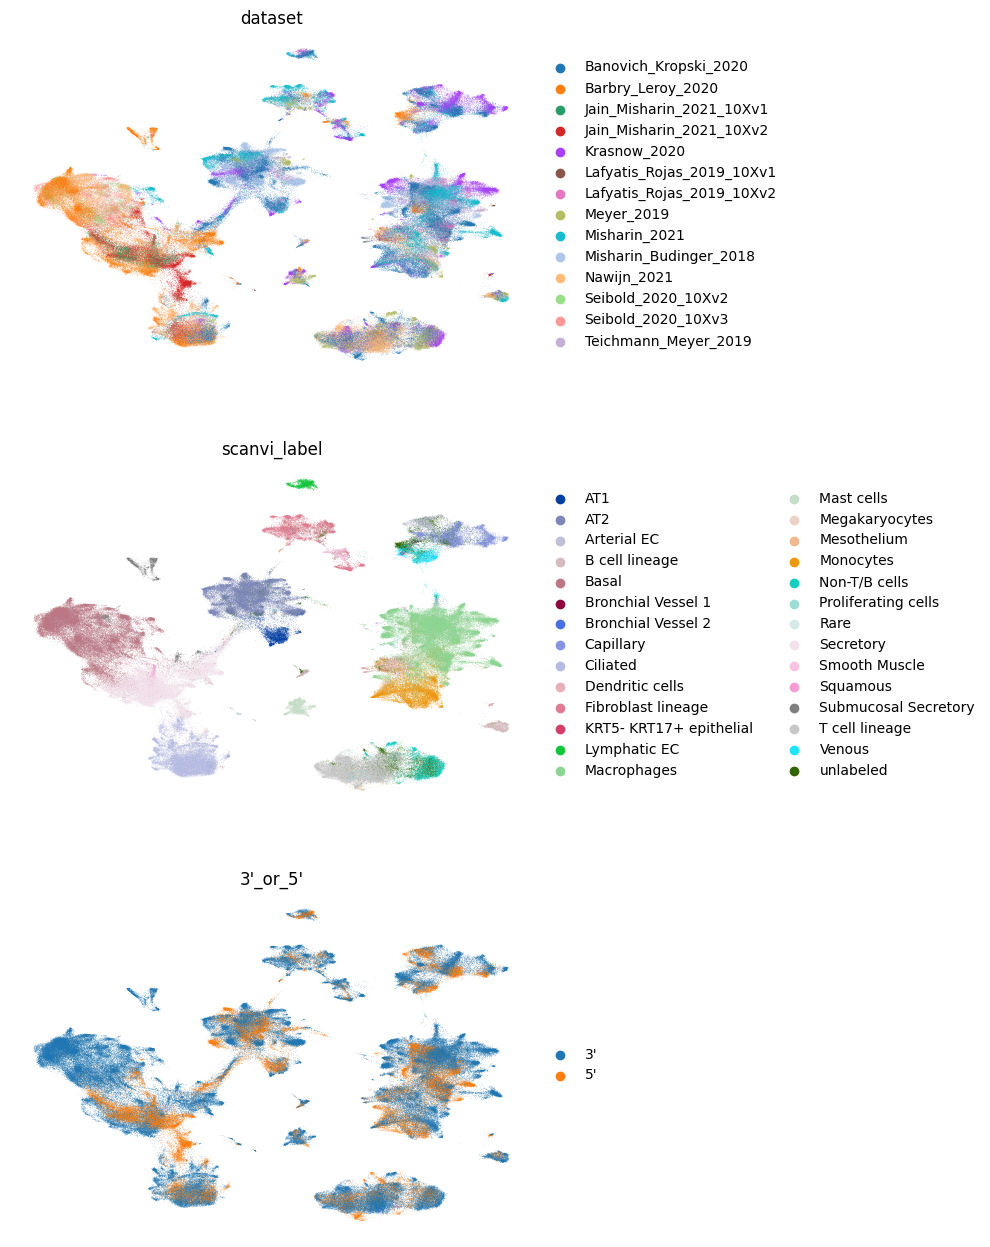

In [29]:
sc.pl.umap(
    adata_latent_subset,
    color=["dataset", "scanvi_label", "3'_or_5'"], # dataset is the batch key
    ncols=1,
    frameon=False,
)

## 🧐 Debugging PCA/DE - Comparing counts "manually"

In [ ]:
# adata_de = adata.copy()
# adata_de.layers["counts"] = adata_de.X.copy() # preserve counts
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata_de)

In [36]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [37]:
s = adata.X.sum(axis=1)

In [38]:
s

matrix([[10000.001],
        [10000.001],
        [10000.001],
        ...,
        [10000.   ],
        [10000.   ],
        [10000.   ]], dtype=float32)

In [44]:
u = s.clip(-2000, 2000)

/var/folders/xq/p3j66w795v3fb21f7ls9v7l80000gn/T/ipykernel_29182/442144386.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(u, hist=True, kde=True,
/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub/lib/python3.9/site-packages/seaborn/distributions.py:2511: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


<AxesSubplot: ylabel='Density'>

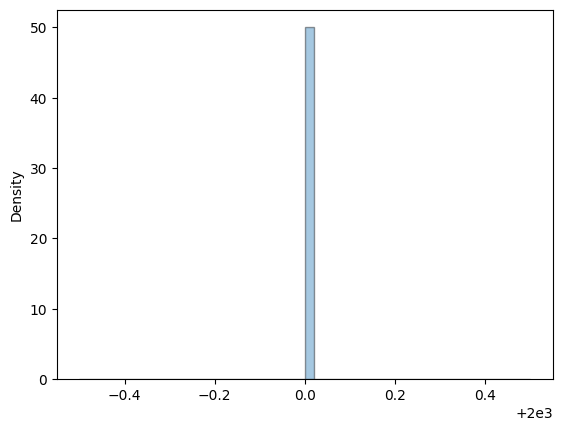

In [45]:
# Density Plot and Histogram of all arrival delays
sns.distplot(u, hist=True, kde=True, 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

In [24]:
idx = adata.X.indices[:10]
# f = np.array(adata.X.todense()).flatten().squeeze()
# f[idx]

g = np.array(adata_de.X.todense()).flatten().squeeze()
g[idx]

array([0.6931472, 0.6931472, 1.0986123, 3.637586 , 0.6931472, 1.0986123,
       2.0794415, 2.9957323, 3.4965076, 0.6931472], dtype=float32)

In [6]:
from scipy.sparse import csr_matrix
x_hat = model_latent.posterior_predictive_sample(n_samples=2)

adata_de_latent = model_latent.adata.copy()
adata_de_latent.X = csr_matrix(np.mean(x_hat, axis=-1)) # csr_matrix(x_hat)
sc.pp.log1p(adata_de_latent)

In [11]:
h = np.array(adata_de_latent.X.todense()).flatten().squeeze()
h[idx]

array([0.91629076, 0.4054651 , 0.        , 4.26268   , 0.        ,
       1.609438  , 2.014903  , 1.2527629 , 3.2580965 , 0.4054651 ],
      dtype=float32)

In [11]:
n_indices = math.floor(len(h)/1000)
idx2 = np.random.randint(0, len(h), n_indices)

In [12]:
len(idx2)

1169768

In [3]:
# g_ad = anndata.read_h5ad("/Users/valehvpa/GitRepos/scvi-hub/local/de/debugging/g.h5ad")
# g = np.array(g_ad.X.todense()).flatten().squeeze()

# h_ad = anndata.read_h5ad("/Users/valehvpa/GitRepos/scvi-hub/local/de/debugging/h.h5ad")
# h = np.array(h_ad.X.todense()).flatten().squeeze()

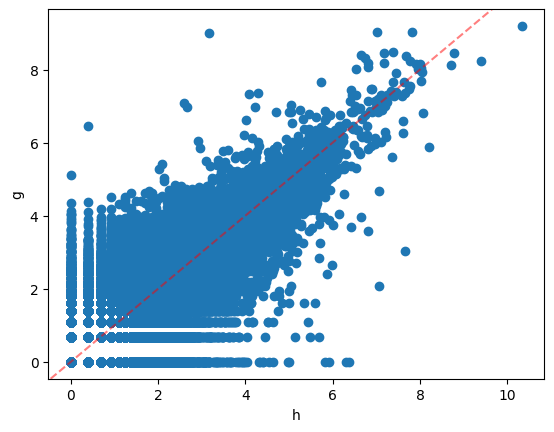

In [14]:
# h[idx], g[idx]

def add_identity(axes, *line_args, **line_kwargs):
    (identity,) = axes.plot([], [], *line_args, **line_kwargs)

    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])

    callback(axes)
    axes.callbacks.connect("xlim_changed", callback)
    axes.callbacks.connect("ylim_changed", callback)
    return axes

plt.scatter(h[idx2], g[idx2])
# plt.scatter(h, g)
ax = plt.gca()
add_identity(ax, color="r", ls="--", alpha=0.5)
plt.xlabel("h")
plt.ylabel("g")
plt.show()